In [ ]:
# Configuration related preprocessing step before mounting the drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144611 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Data Pre Processing

In [ ]:
# Import Necessary Libraries
import os

# Set Directory path for Dataset
os.chdir("/content/drive/My Drive/Projects/Face-Mask-detection")
Dataset='Dataset'
Data_Dir=os.listdir(Dataset)
print(Data_Dir)

['with_mask', 'without_mask']


In [ ]:
# Import necessary libraries
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

img_rows, img_cols = 112, 112

images = []
labels = []

for category in Data_Dir:
    folder_path = os.path.join(Dataset, category)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        img=cv2.imread(img_path)

        try:
            #Coverting the image into gray scale
            grayscale_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            #resizing the gray scaled image into size 56x56 in order to keep size of the images consistent           
            resized_img=cv2.resize(grayscale_img,(img_rows, img_cols))
            images.append(resized_img)
            labels.append(category)
        # Exception Handling in case any error occurs
        except Exception as e:
            print('Exception:',e)
        
images=np.array(images)/255.0
images=np.reshape(images,(images.shape[0],img_rows, img_cols,1))

# Perform one hot encoding on the labels since the label are in textual form
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels = np.array(labels)

(train_X, test_X, train_y, test_y) = train_test_split(images, labels, test_size=0.25, 
                                                      random_state=0)

##  Build Covolutional Neural Network (CNN) Classification Model

In [ ]:
# Import Necessary Keras Libraries
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D

# Define model paramters
num_classes = 2
batch_size = 32

# Build CNN model using Sequential API
model=Sequential()

#First layer group containing Convolution, Relu and MaxPooling layers
model.add(Conv2D(64,(3,3),input_shape=(img_rows, img_cols, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Second layer group containing Convolution, Relu and MaxPooling layers
model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatten and Dropout Layer to stack the output convolutions above as well as cater overfitting
model.add(Flatten())
model.add(Dropout(0.5))

# Softmax Classifier
model.add(Dense(64,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 110, 110, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 53, 53, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

## Plot the Model

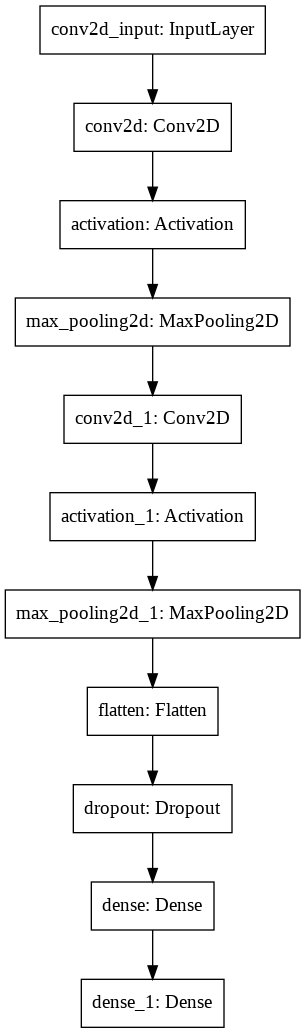

In [ ]:
# Plot the model
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='face_mask_detection_architecture.png')

## Train the Model

In [ ]:
from keras.optimizers import Adam

epochs = 50

model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics = ['accuracy'])

fitted_model = model.fit(
    train_X,
    train_y,
    epochs = epochs,
    validation_split=0.25)

Epoch 1/50
14/14 [==============================] - 1s 59ms/step - loss: 1.1641 - accuracy: 0.4886 - val_loss: 0.6883 - val_accuracy: 0.6939
Epoch 2/50
14/14 [==============================] - 1s 36ms/step - loss: 0.6652 - accuracy: 0.6073 - val_loss: 0.5956 - val_accuracy: 0.6599
Epoch 3/50
14/14 [==============================] - 0s 36ms/step - loss: 0.5526 - accuracy: 0.7260 - val_loss: 0.6485 - val_accuracy: 0.6190
Epoch 4/50
14/14 [==============================] - 1s 36ms/step - loss: 0.5196 - accuracy: 0.7420 - val_loss: 0.4361 - val_accuracy: 0.7823
Epoch 5/50
14/14 [==============================] - 1s 36ms/step - loss: 0.3781 - accuracy: 0.8425 - val_loss: 0.3855 - val_accuracy: 0.8231
Epoch 6/50
14/14 [==============================] - 1s 36ms/step - loss: 0.3093 - accuracy: 0.8653 - val_loss: 0.3156 - val_accuracy: 0.8367
Epoch 7/50
14/14 [==============================] - 1s 36ms/step - loss: 0.2781 - accuracy: 0.8858 - val_loss: 0.3022 - val_accuracy: 0.8707
Epoch 8/50
14

## Plot the Training Loss & Accuracy

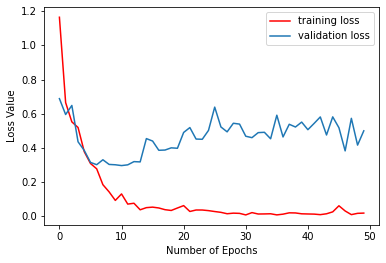

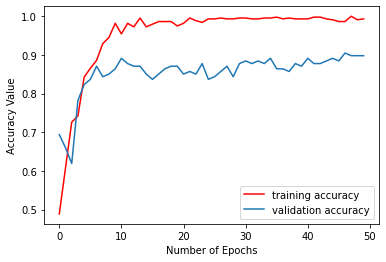

In [ ]:
from matplotlib import pyplot as plt
# Plot Training and Validation Loss
plt.plot(fitted_model.history['loss'],'r',label='training loss')
plt.plot(fitted_model.history['val_loss'],label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.plot(fitted_model.history['accuracy'],'r',label='training accuracy')
plt.plot(fitted_model.history['val_accuracy'],label='validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

## Save or Serialize the Model

In [ ]:
# Save or Serialize the model with the name face_mask_detection_alert_system
model.save('face_mask_detection_alert_system.h5')